# IA SOLVE : Othello

## Player performance analysis

The data was generated from the results of the simulations on our program. The simulations were performed by varying the parameters, the players (MinMax, Alpha-Beta, MCTS, Random ...) and the starting color. More information will be given in the sub-sections. To start using this notebook, you must have the file "data_othello.cvs". If it is not too heavy it will be deposited on git (you will maybe need to unzip it).

In [467]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [537]:
data = pd.read_csv('./data_othello.csv')
display(data.head())
input_shape = data.shape
print("Input shape : {}".format(input_shape))

,Player 1,PLayer 2,Liste Moves,Score,UCB 1,UCB2,it 1,it 2,th 1,th 2,depth 1,depth 2
0,Random,Random,"[((3, 2), 1), ((2, 2), -1), ((2, 3), 1), ((2, ...",-12,0.14,0.14,20.0,20.0,10.0,10.0,3.0,3.0
1,Random,Random,"[((2, 3), 1), ((2, 2), -1), ((2, 1), 1), ((1, ...",10,0.14,0.14,20.0,20.0,10.0,10.0,3.0,3.0
2,Random,Random,"[((5, 4), 1), ((3, 5), -1), ((2, 5), 1), ((5, ...",0,0.14,0.14,20.0,20.0,10.0,10.0,3.0,3.0
3,Random,Random,"[((4, 5), 1), ((5, 3), -1), ((3, 2), 1), ((4, ...",-6,0.14,0.14,20.0,20.0,10.0,10.0,3.0,3.0
4,Random,Random,"[((5, 4), 1), ((3, 5), -1), ((2, 6), 1), ((5, ...",-4,0.14,0.14,20.0,20.0,10.0,10.0,3.0,3.0


Input shape : (15618, 12)


### Dataset Transformation

For a basic analysis we will drop the list of the moves played during the game as we don't need it yet.

For a basic analysis we will drop the list of the moves played during the game as we don't need it yet. We will also focus our analysis on "random player" against all other player algorithms. This will be a good start to compare "general" performance.

In [538]:
df = data.drop(['Liste Moves'], axis = 1) # We will not use it for the analysis
df = df.astype({"Player 1": 'category', "PLayer 2" : 'category'})

def get_win(row) -> int :
    """
    Return 1 if the IA player won else -1 (0 = equality)
    """
    if (row['Player 1'] != 'Random' and row['Score'] > 0) or (row['PLayer 2'] != 'Random' and row['Score'] < 0) :
        return 1
    elif row['Score'] == 0 :
        return 0
    elif (row['Player 1'] == 'Random' and row['PLayer 2'] == 'Random' and row['Score'] > 0):
        return 1 # Random vs Random we will get the player 1 as a reference
    else :
        return 0 # for the moment we are just loking at win

df['win'] = df.apply(lambda row: get_win(row), axis=1)

def merge_players(row): 
    """
    Merge player 1 and player 2 to remove the 'useless' player (random)
    Merge also the parameters
    """
    if row['Player 1'] != 'Random' : 
        return str(row['Player 1']) + ";" + str(row['UCB 1']) + ";" + str(row['it 1']) + ";" + str(row['th 1']) + ";" + str(row['depth 1'])
    else :
        return str(row['PLayer 2']) + ";" + str(row['UCB2']) + ";" + str(row['it 2'])+ ";" + str(row['th 2'])+ ";" + str(row['depth 2'])
    
df['Player'] = df.apply(lambda row: merge_players(row), axis = 1)
df[['Player', 'UCB', 'it', 'th', 'depth']] = df.Player.str.split(";",expand=True)
df2 = df.drop(df.iloc[:, 0:2].columns, axis=1) # Remove previous columns
df2 = df2.drop(df2.iloc[:, 1:9].columns, axis=1) # Remove previous columns
display(df2.head()) # UCB, it, th, depth are useless for random player
print("Input shape : {}".format(df2.shape))
        

,Score,win,Player,UCB,it,th,depth
0,-12,0,Random,0.14,20.0,10.0,3.0
1,10,1,Random,0.14,20.0,10.0,3.0
2,0,0,Random,0.14,20.0,10.0,3.0
3,-6,0,Random,0.14,20.0,10.0,3.0
4,-4,0,Random,0.14,20.0,10.0,3.0


Input shape : (15618, 7)


### Player Random

We quickly check that our "random player" is really random. To do this we can compare the winning results. We expect to have a win score of 50%, according to our data set where a win is +1 and a loose -1, we should find something near 0.

In [470]:
df_random = df2.loc[df2['Player'] == 'Random']
df_random_win = df_random['win']
print("Input shape : {}".format(df_random.shape))
print(df_random_win.mean())

Input shape : (4202, 7)
0.44597810566396956


In our dataset, over 900 games we get an average of -0.0.388. So close to 0 as we expected. We can also check the distribution of the score. If the game is correctly programmed, the score data should follow a normal distribution.

<img src="./images/Random_Player_Score_Distribution.png">


In [500]:
from scipy.stats import shapiro
import seaborn as sns

df_random_score = df_random['Score']
x1, pvalue1 = shapiro(df_random_score)
# print(pvalue1)
# g = sns.displot(df_random_score, kde=True)
# g.fig.suptitle('Score Distribution for Random Player')
# g.savefig('./images/Random_Player_Score_Distribution.png')

1.0928156370937359e-06


## MinMax :

The data were generated from depth 1 to depth 3 (beyond this depth the calculation time becomes too long).

In [499]:
df_minmax = df2.loc[df2['Player'] == 'MinMax']
df_minmax = df_minmax.drop(df_minmax.iloc[:, 2:6].columns, axis=1)
df_minmax = df_minmax.astype({"depth": 'category'})

print(df_minmax.shape) # result (1460, 7)
df_minmax_1 = df_minmax.loc[df_minmax['depth'] == '1.0']
df_minmax_2 = df_minmax.loc[df_minmax['depth'] == '2.0']
df_minmax_3 = df_minmax.loc[df_minmax['depth'] == '3.0']
# display(df_minmax.groupby('depth', as_index=False)['win'].count())
# p = sns.barplot('depth', 'win',data =df_minmax)
# p.set_title('Win mean for each Depth of MinMax')
# fig = p.get_figure()
# fig.savefig('./images/MinMax_Win_Mean.png')

(681, 3)


<img src="./images/MinMax_Win_Mean.png">

As we can see on the barplot, our MinMax is really effective against player Random with a win ratio of 0.9 (full win will be equal to 1).

However, there is no significant difference between the different depths (1, 2, 3) in the results. Several hypotheses can be put forward with regard to our results:

* There is an error in our algortihm
* We are not deep enough to observe a difference
* Our heuristic is relatively powerful against random



## Alpha-Beta :

The data were generated from depth 1 to depth 6 (beyond this depth the calculation time becomes too long).

### FailSoft alpha-beta:

improvement of the alpha-beta algorithm proposed by John Philip Fishburn .

#### Concept
Implementations of alpha–beta pruning can often be delineated by whether they are "fail-soft," or "fail-hard". With fail-soft alpha–beta, the alphabeta function may return values (v) that exceed (v < α or v > β) the α and β bounds set by its function call arguments. In comparison, fail-hard alpha–beta limits its function return value into the inclusive range of α and β. The main difference between fail-soft and fail-hard implementations is whether α and β are updated before or after the cutoff check. If they are updated before the check, then they can exceed initial bounds and the algorithm is fail-soft.

In [501]:
df_failsoft = df2.loc[df2['Player'] == 'Failsoft']
df_failsoft = df_failsoft.drop(df_failsoft.iloc[:, 2:6].columns, axis=1)
df_failsoft = df_failsoft.astype({"depth": 'category'})

print(df_failsoft.shape) # result (1537, 3)

display(df_failsoft.groupby('depth', as_index=False)['win'].mean())
# p = sns.barplot('depth', 'win',data =df_failsoft)
# p.set_title('Win mean for each depth of FailSoft')
# fig = p.get_figure()
# fig.savefig('./images/FailSoft_Win_Mean.png')

(1537, 3)


,depth,win
0,1.0,0.913333
1,2.0,0.955607
2,3.0,0.958333
3,4.0,0.966507


#### Result :

<img src="./images/FailSoft_Win_Mean.png">

The results seem consistent. As the depth increases, the win rate increases. Moreover, we are able to descend to a deeper level in a shorter time than the minmax agorithm.

## MCTS:

The data were generated by varying the following parameters:
* UBC : [0, 0.1, 0.1416, 0.2, 0.5, 1]
* Iteration : [10, 20, 30, 70, 100]
* Depth : [2, 5, 10, 30]

(8496, 6)


,it,UCB,th,win
0,10.0,0.0,2.0,0.793333
1,10.0,0.1,2.0,0.780000
2,10.0,0.2,2.0,0.805000
3,10.0,0.5,2.0,0.826667
4,10.0,1.0,2.0,0.810000
5,20.0,0.0,2.0,0.876847
6,20.0,0.1,2.0,0.903333
7,20.0,0.2,2.0,0.920000
8,20.0,0.5,2.0,0.923333
9,20.0,1.0,2.0,0.916667


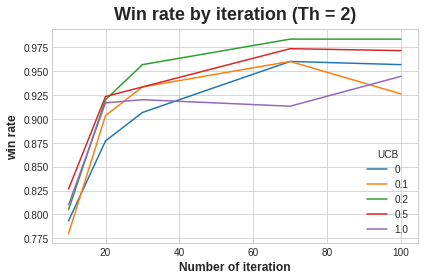

In [541]:
df_MCTS = df2.loc[df2['Player'] == 'MCTS']
df_MCTS = df_MCTS.drop(df_MCTS.iloc[:, 6:].columns, axis=1)
print(df_MCTS.shape) # result (5444, 6)

# TH 2
gf = df_MCTS.loc[df_MCTS['th'] == '2.0']
gf = gf.groupby(['it','UCB','th'], as_index=False)['win'].mean()
gf = gf.astype({'it':'float'})
gf = gf.sort_values(by=['it'])
display(gf.groupby(['it','UCB','th'], as_index=False)['win'].mean())
x1 = gf.loc[gf['UCB'] == '0.0']
x2 = gf.loc[gf['UCB'] == '0.1']
x3 = gf.loc[gf['UCB'] == '0.2']
x4 = gf.loc[gf['UCB'] == '0.5']
x5 = gf.loc[gf['UCB'] == '1.0']

plt.plot(x1['it'], x1['win'], label = '0')
plt.plot(x2['it'], x2['win'], label = '0.1')
plt.plot(x3['it'], x3['win'], label = '0.2')
plt.plot(x4['it'], x4['win'], label = '0.5')
plt.plot(x5['it'], x5['win'], label = '1.0')
plt.title('Win rate by iteration (Th = 2)')
plt.xlabel('Number of iteration')
plt.ylabel('win rate')
plt.legend(title='UCB')
plt.savefig('./images/MCTS_Win_by_it.png')
plt.show()

<img src="./images/MCTS_Win_by_it.png">

threshold fixed at 2


#### ITERATION

First, let's focus on the influence of the iteration on the win rate. It seems obvious that as the number of iterations increases, the win rate increases (with an anomaly on our graph for the UCB set at 0.1). This is logical, the more we increase the number of iterations the more our graph is correctly informed.

#### UCB :

From our graph we can see that the UCB will also influence our win rate. We notice two phases [0, 0.1] and [0.5, 1]. On the first phase the UCB allows to increase the win rate faster and on the second one, a too strong UCB cause an early stagnation of  win rate. The best UCB seems to be close to 0.2. We can refine our search if we have more time.

The results are consistent with the theory we have seen so far. The most commonly used UCB is the square root of 2.
For the rest of the analysis we generated the data from a UCB value of 0.14